# Importing neccessary libraries and dataset

In [1]:
!pip install contractions
!pip install nltk
!pip install autocorrect 
!pip install --upgrade matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622382 sha256=adc2e392a2ab19352a97e37901d1348555c4dd75535226471fd20444a35dc601
  Stored in directory: /root/.cache/pip/wheels/54/d4/37/8244101ad50b0f7d9bffd93ce58ed7991ee1753b290923934b
Successfully built autocorrect


In [2]:
import string # from some string manipulation tasks
import nltk # natural language toolkit
import re # regex
from string import punctuation # solving punctuation problems
from nltk.corpus import stopwords # stop words in sentences
from nltk.stem import WordNetLemmatizer # For stemming the sentence
from nltk.stem import SnowballStemmer # For stemming the sentence
from contractions import contractions_dict # to solve contractions
from autocorrect import Speller #correcting the spellings
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

#Libraries for general purpose
import matplotlib.pyplot as plt
import seaborn as sns


#Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
import numpy as np
import pandas as pd

df = pd.read_csv('../input/cyberbullying-classification/cyberbullying_tweets.csv')
df['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

**There is not much imbalance between different cyberbulling type. other_cyberbulling will be removed since it may cause a confusion for the models with other cyberbullying class.**

In [4]:
df.drop(df[df['cyberbullying_type'] == 'other_cyberbullying'].index, inplace = True)
df['cyberbullying_type'].value_counts()

religion             7998
age                  7992
gender               7973
ethnicity            7961
not_cyberbullying    7945
Name: cyberbullying_type, dtype: int64

# Dataset Preprocessing

In [5]:
# Renaming Categories
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})

In [6]:
# Checking 10 samples
df.sample(10)

,text,sentiment
23285,U can't speak who was given a BIG land and 65 ...,religion
7670,I need to get this college shit going I'm bore...,not_cyberbullying
16317,I think if I want to shiplap every wall in my ...,religion
17509,As opposed to what you doing. It’s amazing how...,religion
603,Which was my first choice.,not_cyberbullying
20159,Wow @chancetherapper did you read Ye’s intervi...,religion
44689,I'm ashamed I'm half white ! I don't want to b...,ethnicity
45473,UPGRADES PEOPLE UPGRADES! ur first drawing was...,ethnicity
14596,@FuzzyMooseBaby I expect nothing advanced from...,gender
21846,Why US? Ask you king first to ban India you id...,religion


**Converting categories into numbers**

In [7]:
df["sentiment"].replace({"religion": 1, "age": 2, "gender": 3, "ethnicity": 4, "not_cyberbullying": 5}, inplace=True)

In [8]:
sentiments = ["religion","age","gender","ethnicity","not bullying"]

**Preprocessing: Tokenize sentences, Change to lower case, Correct spelling, Remove numbers, Remove punctuation, Remove stopwords, Normalize (Lemmatize or Lemmatization)**

In [9]:
!pip install emoji

**Predefined functions for text cleaning**

In [10]:
#@title

#Text cleaning
import re, string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

#Clean emojis from text
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji

#Remove punctuations, links, stopwords, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    text =' '.join(word for word in text.split() if len(word) < 14) # remove words longer than 14 characters
    return text

#remove contractions
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the "#" symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as "&" and "$" present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

#Remove multiple sequential spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

#Stemming
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

#Lemmatization 
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])

#Then we apply all the defined functions in the following order
def preprocess(text):
    text = strip_emoji(text)
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    return text

In [11]:
texts_cleaned = []
for t in df.text:
    texts_cleaned.append(preprocess(t))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  del sys.path[0]


In [12]:
df['text_clean'] = texts_cleaned

**Clean text**

In [13]:
df.head()

,text,sentiment,text_clean
0,"In other words #katandandre, your food was cra...",5,word katandandr food crapilici mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,5,aussietv white mkr theblock today sunris studi...
2,@XochitlSuckkks a classy whore? Or more red ve...,5,classi whore red velvet cupcak
3,"@Jason_Gio meh. :P thanks for the heads up, b...",5,meh p thank head concern anoth angri dude twitter
4,@RudhoeEnglish This is an ISIS account pretend...,5,isi account pretend kurdish account like islam...


**Checking tweet duplicates**

In [14]:
df["text_clean"].duplicated().sum()

1049

**There are around 1000 duplicates. We will remove them at the next cell.**

In [15]:
df.drop_duplicates("text_clean", inplace=True)

In [16]:
df.sentiment.value_counts()

1    7946
2    7884
4    7746
5    7637
3    7607
Name: sentiment, dtype: int64

**After removing duplicates, the value counts per sentiment is shown above. </br>
There is only a few difference (350) on the sentiment with most text and the sentiment with least text so there is no major imbalance on the data.**

# Checking tweet length

In [17]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [18]:
df['text_len'] = text_len

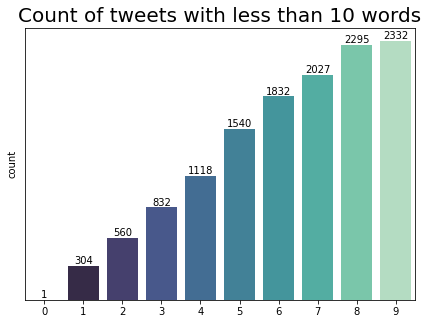

In [19]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [20]:
# checking long tweets
df.sort_values(by=['text_len'], ascending=False)

,text,sentiment,text_clean,text_len
44035,You so black and white trying to live like a n...,4,black white tri live like nigger pahahahaha co...,187
45165,"@hermdiggz: “@tayyoung_: FUCK OBAMA, dumb ass ...",4,fuck obama dumb ass nigger bitch ltthi whore s...,162
33724,"... I don't feel guilty for killing him, I jus...",2,feel guilti kill feel guilti enjoy torment sin...,137
1317,@EurekAlertAAAS: Researchers push to import to...,5,research push import top antibulli program us ...,137
47037,@Purely_Ambition: Sooo mad. RT @TracePeterson ...,4,sooo mad rt fuck obama dumb nigger go switzerl...,125
...,...,...,...,...
1607,@harmlesstree2 Here7 https://t.co/xWJzpSodGj,5,here7,1
6696,@LiamTighe Rebecca who?,5,rebecca,1
558,@root_tim this is my work :),5,work,1
3462,@jaredchase killing you how?,5,kill,1


**Removing tweets with less than 4 words and more than 100 words as they can be outliers**

In [21]:
df = df[df['text_len'] > 3]
df = df[df['text_len'] < 100]

In [22]:
df

,text,sentiment,text_clean,text_len
0,"In other words #katandandre, your food was cra...",5,word katandandr food crapilici mkr,5
1,Why is #aussietv so white? #MKR #theblock #ImA...,5,aussietv white mkr theblock today sunris studi...,10
2,@XochitlSuckkks a classy whore? Or more red ve...,5,classi whore red velvet cupcak,5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",5,meh p thank head concern anoth angri dude twitter,9
4,@RudhoeEnglish This is an ISIS account pretend...,5,isi account pretend kurdish account like islam...,8
...,...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",4,black ppl expect anyth depend anyth yet free p...,21
47688,Turner did not withhold his disappointment. Tu...,4,turner withhold turner call court abomin concl...,28
47689,I swear to God. This dumb nigger bitch. I have...,4,swear god dumb nigger bitch got bleach hair re...,13
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,4,yea fuck rt your nigger fuck unfollow fuck dum...,10


# Creating a word cloud

In [23]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt #to display our wordcloud
from PIL import Image #to load our image
import numpy as np #to get the color of our image

**0 - religion </br>
1 - age  </br> 
2 - gender </br>
3 - ethnicity </br>
4 - cyberbullying**

# Turning text into numbers

In [25]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline


tfidf = TfidfTransformer()
clf = CountVectorizer()

X_cv =  clf.fit_transform(df['text_clean'])

tf_transformer = TfidfTransformer(use_idf=True).fit(X_cv)
X_tf = tf_transformer.transform(X_cv)

In [26]:
X_tf

<37114x32979 sparse matrix of type '<class 'numpy.float64'>'
	with 504608 stored elements in Compressed Sparse Row format>

# Train test split

In [27]:
from sklearn.model_selection import train_test_split
# train and test
X_train, X_test, y_train, y_test = train_test_split(X_tf, df['sentiment'], test_size=0.20, stratify=df['sentiment'], random_state=42)

In [28]:
y_train.value_counts()

0    6314
1    6264
3    6167
2    5849
4    5097
Name: sentiment, dtype: int64

**after checking the training set, there are imbalance of data and it may cause a bias in training the model. Oversampling using SMOTE will be used to balance the train dataset.**

# SMOTE

In [29]:
from imblearn.over_sampling import SMOTE
vc = y_train.value_counts()
while (vc[0] != vc[4]) or (vc[0] !=  vc[2]) or (vc[0] !=  vc[3]) or (vc[0] !=  vc[1]):
    smote = SMOTE(sampling_strategy='minority')
    X_train, y_train = smote.fit_resample(X_train, y_train)
    vc = y_train.value_counts()

y_train.value_counts()

4    6314
0    6314
3    6314
2    6314
1    6314
Name: sentiment, dtype: int64

**Now the training set is balanced and ready to be feed into the ml model.**

# Model Training

## Naive Bayes

In [30]:
from sklearn.naive_bayes import MultinomialNB
nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)

MultinomialNB()

## **K Nearest Neighbor**

In [31]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

## Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

# Model Evaluation

## **Classification Report**

In [33]:
from sklearn.metrics import classification_report
nb_pred = nb_clf.predict(X_test)
print('Classification Report for Naive Bayes:\n',classification_report(y_test, nb_pred, target_names=sentiments))

Classification Report for Naive Bayes:
               precision    recall  f1-score   support

    religion       0.85      0.97      0.91      1579
         age       0.80      0.98      0.88      1566
      gender       0.88      0.85      0.86      1462
   ethnicity       0.90      0.91      0.90      1542
not bullying       0.84      0.49      0.62      1274

    accuracy                           0.85      7423
   macro avg       0.85      0.84      0.83      7423
weighted avg       0.85      0.85      0.84      7423



In [34]:
knn_pred = knn_clf.predict(X_test)
print('Classification Report for Naive Bayes:\n',classification_report(y_test, knn_pred, target_names=sentiments))

Classification Report for Naive Bayes:
               precision    recall  f1-score   support

    religion       0.92      0.38      0.54      1579
         age       0.92      0.58      0.71      1566
      gender       0.78      0.81      0.79      1462
   ethnicity       0.90      0.82      0.86      1542
not bullying       0.37      0.83      0.51      1274

    accuracy                           0.67      7423
   macro avg       0.78      0.68      0.68      7423
weighted avg       0.79      0.67      0.69      7423



In [35]:
rf_pred = rf_clf.predict(X_test)
print('Classification Report for Random Forest:\n',classification_report(y_test, rf_pred, target_names=sentiments))

Classification Report for Random Forest:
               precision    recall  f1-score   support

    religion       0.97      0.95      0.96      1579
         age       0.98      0.98      0.98      1566
      gender       0.95      0.87      0.91      1462
   ethnicity       0.99      0.99      0.99      1542
not bullying       0.80      0.89      0.84      1274

    accuracy                           0.94      7423
   macro avg       0.94      0.94      0.94      7423
weighted avg       0.94      0.94      0.94      7423



## Confusion Matrix

In [36]:
#@title
from sklearn.metrics import confusion_matrix 
# Source code credit for this function: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

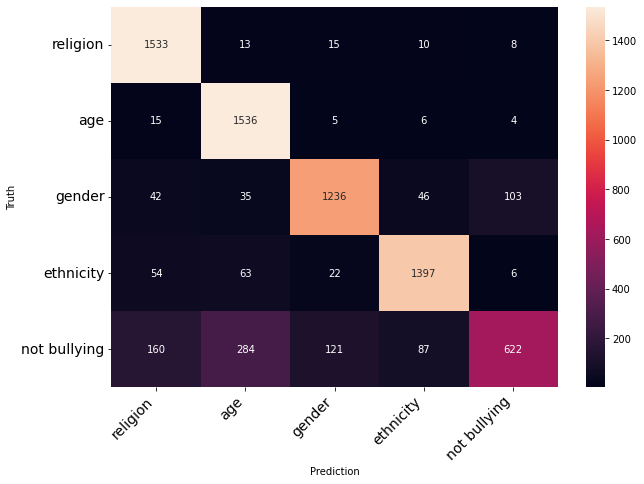

In [37]:
# Naive Bayes
cm = confusion_matrix(y_test,nb_pred)
print_confusion_matrix(cm,sentiments)

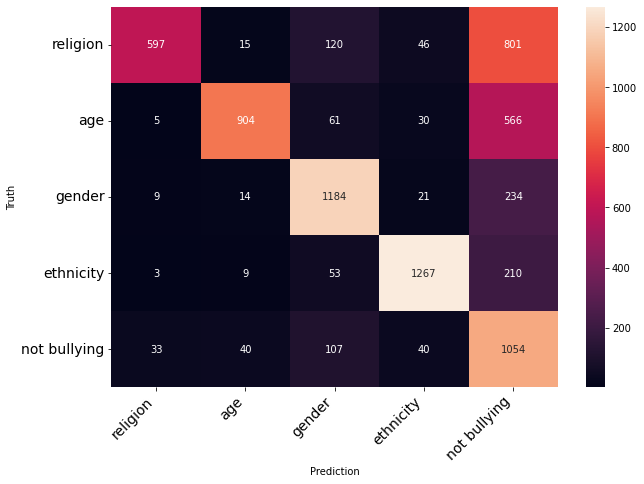

In [38]:
# K Nearest Neighbor
cm = confusion_matrix(y_test,knn_pred)
print_confusion_matrix(cm,sentiments)

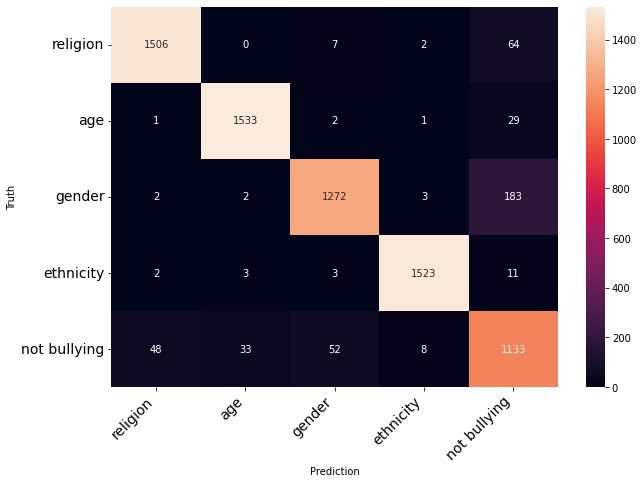

In [39]:
# Random Forest
cm = confusion_matrix(y_test,rf_pred)
print_confusion_matrix(cm,sentiments)

## Cross Validation Score

In [40]:
from sklearn.model_selection import cross_val_score

NB_cv_score = cross_val_score(nb_clf,X_train, y_train, cv=3)
KNN_cv_score = cross_val_score(knn_clf,X_train, y_train, cv=3)
RF_cv_score = cross_val_score(rf_clf,X_train, y_train, cv=3)

print('Cross validation score (Multinomial Naive Bayes Classifier):', NB_cv_score.mean())
print('Cross validation score (K Nearest Neighbor):', KNN_cv_score.mean())
print('Cross validation score (Random Forest Classifier):', RF_cv_score.mean())

Cross validation score (Multinomial Naive Bayes Classifier): 0.8483372211568829
Cross validation score (K Nearest Neighbor): 0.7252789371778933
Cross validation score (Random Forest Classifier): 0.9391828556173835


# Trying the best model using another dataset

The dataset was collected from these 4 kaggle datasets.</br>
https://www.kaggle.com/datasets/saurabhshahane/cyberbullying-dataset?select=twitter_racism_parsed_dataset.csv
https://www.kaggle.com/datasets/vkrahul/twitter-hate-speech?select=train_E6oV3lV.csv
https://www.kaggle.com/datasets/ilhamfp31/indonesian-abusive-and-hate-speech-twitter-text
https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset

In [41]:
test_data = pd.read_csv('../input/cb-test-data/cyberbullying_test_data.csv')
test_data["sentiments"].replace({"religion": 0, "age": 1, "gender": 2, "ethnicity": 3, "not_cyberbullying": 4}, inplace=True)

In [42]:
test_data.tail()

,text,sentiments
95,time to eat with my bae swalscha Ã°ÂŸÂ˜ÂÃ¢ÂœÂ...,4
96,ilovethesecret #lawofattraction #quiz #love ...,4
97,it seems like the only place with action here ...,4
98,@user brilliant service at your kettering bran...,4
99,i am thankful for now. #thankful #positive,4


In [43]:
# Cleaning text test set
import string
test_texts_cleaned = []
for t in test_data.text:
    test_texts_cleaned.append(preprocess(t))
test_texts_cleaned = clf.transform(test_texts_cleaned)

tf_transformer = TfidfTransformer(use_idf=True).fit(test_texts_cleaned)
X_tf_test = tf_transformer.transform(test_texts_cleaned)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  del sys.path[0]


**Classification Report**

In [44]:
from sklearn.metrics import classification_report
all_predictions = rf_clf.predict(test_texts_cleaned)
print(classification_report(test_data["sentiments"], all_predictions))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        20
           1       1.00      0.35      0.52        20
           2       0.76      0.95      0.84        20
           3       0.67      0.10      0.17        20
           4       0.47      1.00      0.63        20

    accuracy                           0.68       100
   macro avg       0.76      0.68      0.62       100
weighted avg       0.76      0.68      0.62       100



**The best model only has a 66% accuracy in the other dataset. Perhaps it might be too different from the training data that the model was trained.**

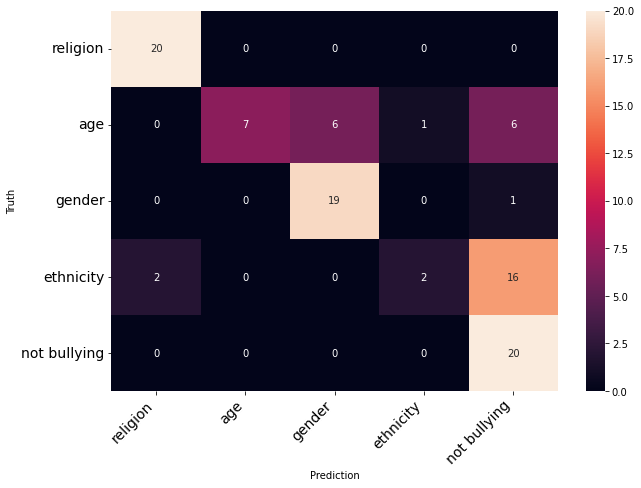

In [45]:
cm = confusion_matrix(test_data["sentiments"],all_predictions)
print_confusion_matrix(cm,sentiments)

**huge number from ethnicity classified as not bullying**

## Test of New dataset to Random Forest

In [46]:
rf_predictions = rf_clf.predict(test_texts_cleaned)

In [47]:
rf_predictions

array([1, 1, 1, 4, 1, 4, 4, 1, 1, 2, 3, 2, 2, 2, 2, 4, 2, 1, 4, 4, 3, 3,
       4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [48]:
#@title
def predict_custom(prediction):

  results = []

  for pred in prediction:

    if pred == 0:
      a = "religion"
      results.append(a)
    elif pred == 1:
      b = "age"
      results.append(b)
    elif pred == 2:
      c = "gender"
      results.append(c)
    elif pred == 3:
      d = "ethnicity"
      results.append(d)
    elif pred == 4:
      e = "not_cyberbullying"
      results.append(e)

  return results

In [49]:
rf_sentiments = predict_custom(rf_predictions)

In [50]:
sentiments = predict_custom(test_data['sentiments'])

In [51]:
test_data.drop('sentiments', axis=1, inplace=True)
test_data['sentiments'] = sentiments

In [52]:
test_data['rf_predicted'] = rf_sentiments 

**Sample Prediction of RF on the test data.**

In [53]:
test_data

,text,sentiments,rf_predicted
0,"""@2015seniorprobs: I probably would not mind s...",age,age
1,CauseWereGuys: On my way to fuck yo bitch me ...,age,age
2,#HonestyHour in middle school hoes used to cal...,age,age
3,#InMiddleSchool i was fat as hell and was a ba...,age,not_cyberbullying
4,#southcarolina has a high school graduation ra...,age,age
...,...,...,...
95,time to eat with my bae swalscha Ã°ÂŸÂ˜ÂÃ¢ÂœÂ...,not_cyberbullying,not_cyberbullying
96,ilovethesecret #lawofattraction #quiz #love ...,not_cyberbullying,not_cyberbullying
97,it seems like the only place with action here ...,not_cyberbullying,not_cyberbullying
98,@user brilliant service at your kettering bran...,not_cyberbullying,not_cyberbullying
